In [1]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mlutils
reload(mlutils)
%matplotlib inline

/opt/anaconda/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d




### RECOMMENDATION

- close all applications
- install Maxthon browser http://www.maxthon.com
- open only VirtualBox and Maxthon


## Batch Normalization

See 

- [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/pdf/1502.03167.pdf)

- [Batch normalization: theory and how to use it with Tensorflow](https://towardsdatascience.com/batch-normalization-theory-and-how-to-use-it-with-tensorflow-1892ca0173ad)

- [CS231n Convolutional Neural Networks](http://cs231n.github.io/neural-networks-2/)


**We are using a small dataset based on [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)**

In [2]:
!wget -nc https://s3.amazonaws.com/rlx/mini_cifar.h5

File ‘mini_cifar.h5’ already there; not retrieving.



In [3]:
import h5py
with h5py.File('mini_cifar.h5','r') as h5f:
    x_cifar = h5f["x"][:]
    y_cifar = h5f["y"][:]

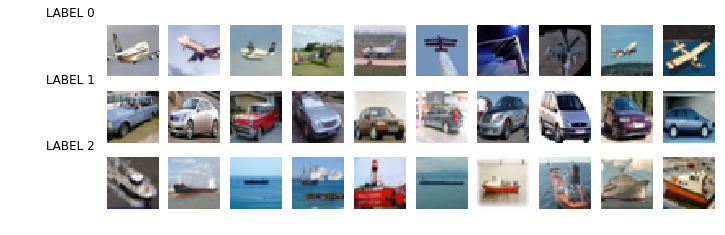

In [4]:
mlutils.show_labeled_image_mosaic(x_cifar, y_cifar)

In [5]:
print np.min(x_cifar), np.max(x_cifar)

0.0 1.0


In [6]:
from sklearn.model_selection import train_test_split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.25)
num_classes = len(np.unique(y_train))
print x_train.shape, y_train.shape, x_test.shape, y_test.shape
print "\ndistribution of train classes"
print pd.Series(y_train).value_counts()
print "\ndistribution of test classes"
print pd.Series(y_test).value_counts()
print "\nnum classes", num_classes

(2253, 32, 32, 3) (2253,) (751, 32, 32, 3) (751,)

distribution of train classes
2    780
0    745
1    728
dtype: int64

distribution of test classes
0    260
1    246
2    245
dtype: int64

num classes 3


## Set up a model with Keras and train

In [8]:
def get_conv_model_A(num_classes, img_size=32, compile=True):
    def norm_init(shape, dtype=None, partition_info=None):
        return tf.keras.backend.random_normal(shape, mean=0.0, stddev=0.01, dtype=dtype)
    
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print "using",num_classes,"classes"
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(15,(4,4), activation="relu", padding="same", 
                                    kernel_initializer=norm_init,
                                    bias_initializer=norm_init)(inputs)
        
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu, 
                                   kernel_initializer=norm_init,
                                   bias_initializer=norm_init)(layers)
    
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [45]:
model = get_conv_model_A(num_classes)
model.summary()
print "\n--- weights ---"
for w in model.get_weights():
    print w.shape

using 3 classes
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 15)        735       
_________________________________________________________________
flatten (Flatten)            (None, 15360)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                245776    
_________________________________________________________________
output_1 (Dense)             (None, 3)                 51        
Total params: 246,562
Trainable params: 246,562
Non-trainable params: 0
_________________________________________________________________

--- weights ---
(4, 4, 3, 15)
(15,)
(15360, 16)
(16,)
(16, 3)
(3,)


In [10]:
def train(model, x_train, y_train, x_test, y_test, batch_size, epochs, model_name=""):
    model.reset_states()
    model.fit(x_train, y_train, epochs=epochs,
              batch_size=batch_size,
              validation_data=(x_test, y_test))
    metrics = model.evaluate(x_test, y_test)
    return {k:v for k,v in zip (model.metrics_names, metrics)}


In [11]:
model = get_conv_model_A(num_classes)
train(model, x_train, y_train, x_test, y_test, batch_size=32, epochs=30, model_name="model_A")

using 3 classes
Train on 2253 samples, validate on 751 samples
Epoch 1/30
2253/2253 [==============================] - 3s 1ms/step - loss: 1.0328 - acc: 0.4505 - val_loss: 0.9585 - val_acc: 0.5353
Epoch 2/30
2253/2253 [==============================] - 2s 964us/step - loss: 0.8810 - acc: 0.6010 - val_loss: 0.8255 - val_acc: 0.6245
Epoch 3/30
2253/2253 [==============================] - 2s 982us/step - loss: 0.8027 - acc: 0.6485 - val_loss: 0.7651 - val_acc: 0.6764
Epoch 4/30
2253/2253 [==============================] - 2s 968us/step - loss: 0.7578 - acc: 0.6649 - val_loss: 0.7343 - val_acc: 0.6897
Epoch 5/30
2253/2253 [==============================] - 2s 974us/step - loss: 0.7062 - acc: 0.6849 - val_loss: 0.7187 - val_acc: 0.6778
Epoch 6/30
2253/2253 [==============================] - 2s 950us/step - loss: 0.6788 - acc: 0.7075 - val_loss: 0.7422 - val_acc: 0.6818
Epoch 7/30
2253/2253 [==============================] - 2s 1ms/step - loss: 0.6301 - acc: 0.7306 - val_loss: 0.7028 - val_a

{'acc': 0.7057256992266435, 'loss': 0.9362054363230414}

In [12]:
def plot_hist(model):
    plt.plot(model.history.history["acc"], label="acc")
    plt.plot(model.history.history["val_acc"], label="val_acc")
    plt.grid()
    plt.legend();
    plt.xlabel("training step")
    plt.ylabel("accuracy")
    plt.ylim(0.4,1.05)


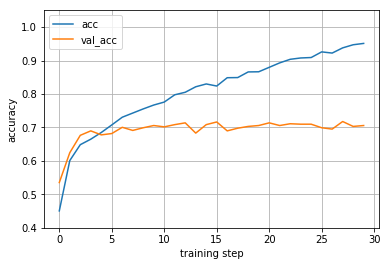

In [13]:
plot_hist(model)

## Standardize full dataset pixel-wise

Given:

- $X^{i}$: image $i$
- $X^{i}_{j|k}$: channel $k$ of pixel $j$ in image $i$
- $S^i$: image $i$ standardized

In pixel wise standardization, each pixel has zero mean and std=1 across the dataset:

- $\mu_{j|k} = \frac{1}{N}\sum_{i=0}^{N-1}X^{i}_{j|k}$
- $\sigma_{j|k} = \frac{1}{N}\sum_{i=0}^{N-1}(X^{i}_{j|k}-\mu_{j|k})^2$

So that:

$$S^{i}_{j|k} = \frac{1}{\sigma_{j|k}}(X^{i}_{j|k} - \mu_{j|k})$$

Observe that we compute one $\mu$ and one $\sigma$ per each pixel and channel across the dataset.

In [14]:
from sklearn.preprocessing import StandardScaler

sx_train = StandardScaler().fit_transform(x_train.reshape(-1,32*32*3)).reshape(-1,32,32,3)
sx_test  = StandardScaler().fit_transform(x_test.reshape(-1,32*32*3)).reshape(-1,32,32,3)


In [15]:
np.min(sx_train), np.max(sx_train)

(-2.448690507303215, 2.4193689284849462)

In [16]:
x_train.shape, sx_train.shape

((2253, 32, 32, 3), (2253, 32, 32, 3))

In [17]:
smodel = get_conv_model_A(num_classes)
train(smodel, sx_train, y_train, sx_test, y_test, batch_size=32, epochs=30, model_name="model_A")

using 3 classes
Train on 2253 samples, validate on 751 samples
Epoch 1/30
2253/2253 [==============================] - 4s 2ms/step - loss: 0.8801 - acc: 0.5881 - val_loss: 0.7955 - val_acc: 0.6418
Epoch 2/30
2253/2253 [==============================] - 3s 2ms/step - loss: 0.6720 - acc: 0.6982 - val_loss: 0.7157 - val_acc: 0.6897
Epoch 3/30
2253/2253 [==============================] - 4s 2ms/step - loss: 0.5786 - acc: 0.7603 - val_loss: 0.7117 - val_acc: 0.6951
Epoch 4/30
2253/2253 [==============================] - 3s 1ms/step - loss: 0.5138 - acc: 0.7843 - val_loss: 0.7039 - val_acc: 0.7217
Epoch 5/30
2253/2253 [==============================] - 3s 1ms/step - loss: 0.4609 - acc: 0.8167 - val_loss: 0.7172 - val_acc: 0.7164
Epoch 6/30
2253/2253 [==============================] - 4s 2ms/step - loss: 0.3939 - acc: 0.8438 - val_loss: 0.7530 - val_acc: 0.7270
Epoch 7/30
2253/2253 [==============================] - 3s 1ms/step - loss: 0.3592 - acc: 0.8566 - val_loss: 0.7499 - val_acc: 0.7417

{'acc': 0.7350199737656767, 'loss': 1.5812440553454363}

Text(0.5,1,'pixel wise standardization')

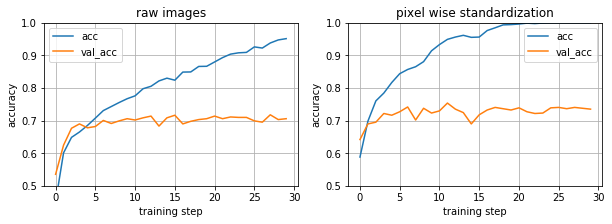

In [18]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plot_hist(model); plt.ylim(0.5,1); plt.title("raw images")
plt.subplot(122)
plot_hist(smodel); plt.ylim(0.5,1); plt.title("pixel wise standardization")

## Standardize each image

each image has zero mean and std=1 

In image wise standardization, each image has zero mean and std=1 across the dataset:

- $\mu^i = \frac{1}{n_j \times n_k}\sum_{j,k}X^{i}_{j|k}$
- $\sigma^i = \frac{1}{n_j \times n_k}\sum_{j,k}(X^{i}_{j|k}-\mu^i)^2$

where $n_j$ and $n_k$ are the number of pixels and the number of channels in im age $i$.

So that:

$$S^{i}_{j|k} = \frac{1}{\sigma^i}(X^{i}_{j|k} - \mu^i)$$


In [19]:
sc = StandardScaler()
sx_train = np.r_[[(i-np.mean(i))/np.std(i) for i in x_train]]
sx_test = np.r_[[(i-np.mean(i))/np.std(i) for i in x_test]]

np.min(sx_train), np.max(sx_train)

(-7.546909042833099, 6.537064736522712)

In [20]:
s2model = get_conv_model_A(num_classes)
train(s2model, sx_train, y_train, sx_test, y_test, batch_size=32, epochs=30, model_name="model_A")

using 3 classes
Train on 2253 samples, validate on 751 samples
Epoch 1/30
2253/2253 [==============================] - 3s 1ms/step - loss: 0.8475 - acc: 0.6014 - val_loss: 0.7558 - val_acc: 0.6897
Epoch 2/30
2253/2253 [==============================] - 3s 1ms/step - loss: 0.6727 - acc: 0.7217 - val_loss: 0.7273 - val_acc: 0.6924
Epoch 3/30
2253/2253 [==============================] - 2s 884us/step - loss: 0.5707 - acc: 0.7683 - val_loss: 0.6862 - val_acc: 0.7190
Epoch 4/30
2253/2253 [==============================] - 3s 1ms/step - loss: 0.4756 - acc: 0.8162 - val_loss: 0.6983 - val_acc: 0.7111
Epoch 5/30
2253/2253 [==============================] - 2s 1ms/step - loss: 0.3998 - acc: 0.8380 - val_loss: 0.7422 - val_acc: 0.7111
Epoch 6/30
2253/2253 [==============================] - 2s 901us/step - loss: 0.3176 - acc: 0.8771 - val_loss: 0.7527 - val_acc: 0.7350
Epoch 7/30
2253/2253 [==============================] - 2s 945us/step - loss: 0.2463 - acc: 0.9086 - val_loss: 0.9747 - val_acc: 

{'acc': 0.7310252997592667, 'loss': 1.649638355492593}

Observe how accuracy (on train data) raises faster. Variance is still high since we have a small dataset.

- why does it raise faster on pixel-wise standardization?
- why does it raise even faster with image-wise standardization?

In both cases we are helping optimization by keeping activations centered in zero and having more meaningful gradients. In image-wise standardization we ensure this property tighter at each image.

Text(0.5,1,'image wise standardization')

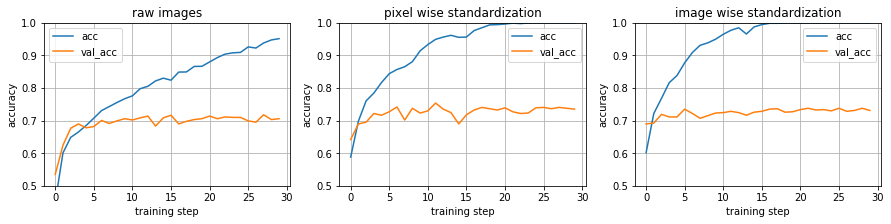

In [21]:
plt.figure(figsize=(15,3))
plt.subplot(131)
plot_hist(model); plt.ylim(0.5,1.06); plt.title("raw images")
plt.subplot(132)
plot_hist(smodel); plt.ylim(0.5,1.05); plt.title("pixel wise standardization")
plt.subplot(133)
plot_hist(s2model); plt.ylim(0.5,1.05); plt.title("image wise standardization")

## ZCA whitening

In [22]:
def zca_whitening(inputs):
    sigma = np.dot(inputs, inputs.T)/inputs.shape[1] #Correlation matrix
    U,S,V = np.linalg.svd(sigma) #Singular Value Decomposition
    epsilon = 0.1                #Whitening constant, it prevents division by zero
    ZCAMatrix = np.dot(np.dot(U, np.diag(1.0/np.sqrt(np.diag(S) + epsilon))), U.T)                     #ZCA Whitening matrix
    return np.dot(ZCAMatrix, inputs)   #Data whitening

In [23]:
sx_train = np.r_[[(i-np.mean(i))/np.std(i) for i in x_train]]
sx_test = np.r_[[(i-np.mean(i))/np.std(i) for i in x_test]]

zx_train = np.r_[[zca_whitening(i.reshape(1,-1)).reshape(i.shape) for i in sx_train]]
zx_test  = np.r_[[zca_whitening(i.reshape(1,-1)).reshape(i.shape) for i in sx_test]]


In [24]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
#zx_train = np.r_[[mm.fit_transform(i.reshape(-1,1)).reshape(i.shape) for i in zx_train]]
#zx_test = np.r_[[mm.fit_transform(i.reshape(-1,1)).reshape(i.shape) for i in zx_test]]

In [25]:
idxs = np.random.permutation(100)[:10]

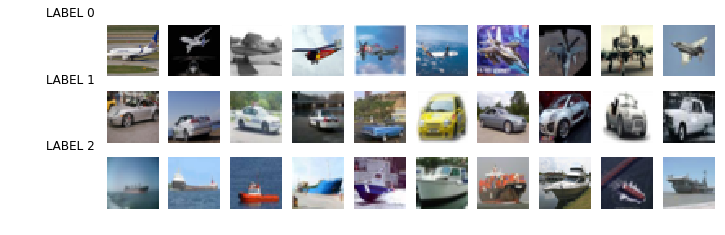

In [26]:
mlutils.show_labeled_image_mosaic(x_train, y_train, idxs=idxs)

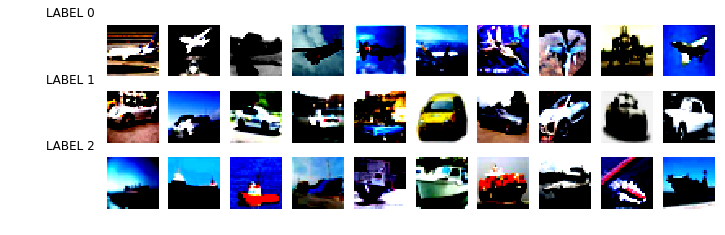

In [27]:
mlutils.show_labeled_image_mosaic(zx_train, y_train, idxs=idxs)

In [28]:
zmodel = get_conv_model_A(num_classes)
train(zmodel, zx_train, y_train, zx_test, y_test, batch_size=32, epochs=30, model_name="model_A")

using 3 classes
Train on 2253 samples, validate on 751 samples
Epoch 1/30
2253/2253 [==============================] - 3s 1ms/step - loss: 0.8596 - acc: 0.6099 - val_loss: 0.7161 - val_acc: 0.6924
Epoch 2/30
2253/2253 [==============================] - 2s 1ms/step - loss: 0.6679 - acc: 0.7062 - val_loss: 0.6998 - val_acc: 0.7004
Epoch 3/30
2253/2253 [==============================] - 2s 964us/step - loss: 0.5431 - acc: 0.7745 - val_loss: 0.6933 - val_acc: 0.7230
Epoch 4/30
2253/2253 [==============================] - 2s 873us/step - loss: 0.4609 - acc: 0.8127 - val_loss: 0.6887 - val_acc: 0.7217
Epoch 5/30
2253/2253 [==============================] - 2s 914us/step - loss: 0.3668 - acc: 0.8571 - val_loss: 0.7369 - val_acc: 0.7217
Epoch 6/30
2253/2253 [==============================] - 2s 896us/step - loss: 0.2933 - acc: 0.8930 - val_loss: 0.8199 - val_acc: 0.7257
Epoch 7/30
2253/2253 [==============================] - 2s 890us/step - loss: 0.2446 - acc: 0.9095 - val_loss: 0.7641 - val_a

{'acc': 0.7430093211435606, 'loss': 1.5209514784431966}

Text(0.5,1,'zca whitening')

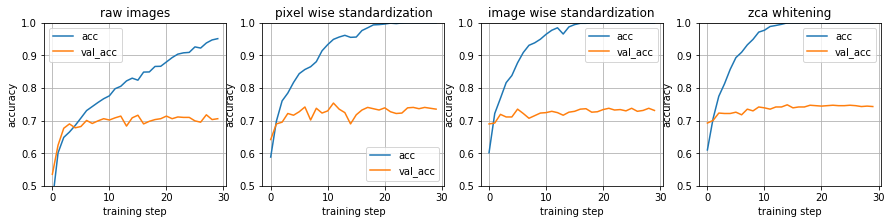

In [29]:
plt.figure(figsize=(15,3))
plt.subplot(141)
plot_hist(model); plt.ylim(0.5,1); plt.title("raw images")
plt.subplot(142)
plot_hist(smodel); plt.ylim(0.5,1); plt.title("pixel wise standardization")
plt.subplot(143)
plot_hist(s2model); plt.ylim(0.5,1); plt.title("image wise standardization")
plt.subplot(144)
plot_hist(zmodel); plt.ylim(0.5,1); plt.title("zca whitening")

Text(0,0.5,'accuracy in train')

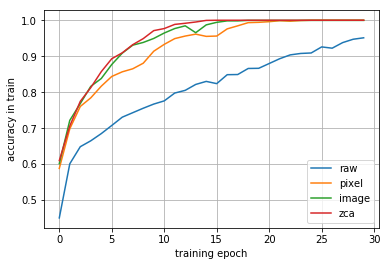

In [30]:
plt.plot(model.history.history["acc"], label="raw");
plt.plot(smodel.history.history["acc"], label="pixel");
plt.plot(s2model.history.history["acc"], label="image");
plt.plot(zmodel.history.history["acc"], label="zca");
plt.grid();
plt.legend();
plt.xlabel("training epoch")
plt.ylabel("accuracy in train")

In [35]:
def get_conv_model_B(num_classes, img_size=32, compile=True):
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print "using",num_classes,"classes"
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(15,(4,4), activation="relu")(inputs)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [36]:
bmodel = get_conv_model_B(num_classes)
train(bmodel, x_train, y_train, x_test, y_test, batch_size=32, epochs=30, model_name="model_A")

using 3 classes
Train on 2253 samples, validate on 751 samples
Epoch 1/30
2253/2253 [==============================] - 3s 1ms/step - loss: 1.0563 - acc: 0.5846 - val_loss: 0.9709 - val_acc: 0.5766
Epoch 2/30
2253/2253 [==============================] - 2s 1ms/step - loss: 0.6118 - acc: 0.7395 - val_loss: 0.8799 - val_acc: 0.6578
Epoch 3/30
2253/2253 [==============================] - 2s 1ms/step - loss: 0.4246 - acc: 0.8238 - val_loss: 0.8702 - val_acc: 0.6631
Epoch 4/30
2253/2253 [==============================] - 3s 1ms/step - loss: 0.2820 - acc: 0.8957 - val_loss: 0.7512 - val_acc: 0.7044
Epoch 5/30
2253/2253 [==============================] - 3s 1ms/step - loss: 0.1806 - acc: 0.9387 - val_loss: 0.7042 - val_acc: 0.7124
Epoch 6/30
2253/2253 [==============================] - 3s 1ms/step - loss: 0.1244 - acc: 0.9636 - val_loss: 0.7960 - val_acc: 0.6818
Epoch 7/30
2253/2253 [==============================] - 3s 1ms/step - loss: 0.0844 - acc: 0.9765 - val_loss: 0.7494 - val_acc: 0.7417

{'acc': 0.7509986686801784, 'loss': 1.4214608296255933}

Text(0,0.5,'accuracy in train')

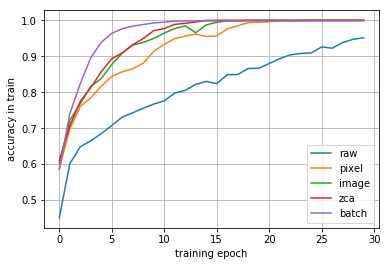

In [37]:
plt.plot(model.history.history["acc"], label="raw");
plt.plot(smodel.history.history["acc"], label="pixel");
plt.plot(s2model.history.history["acc"], label="image");
plt.plot(zmodel.history.history["acc"], label="zca");
plt.plot(bmodel.history.history["acc"], label="batch");
plt.grid();
plt.legend();
plt.xlabel("training epoch")
plt.ylabel("accuracy in train")

observe that batch normalization by itself is, in this case, enough

In [38]:
bzmodel = get_conv_model_B(num_classes)
train(bzmodel, zx_train, y_train, zx_test, y_test, batch_size=32, epochs=30, model_name="model_A")

using 3 classes
Train on 2253 samples, validate on 751 samples
Epoch 1/30
2253/2253 [==============================] - 3s 1ms/step - loss: 1.1093 - acc: 0.5903 - val_loss: 0.8741 - val_acc: 0.6245
Epoch 2/30
2253/2253 [==============================] - 3s 1ms/step - loss: 0.6243 - acc: 0.7501 - val_loss: 0.7376 - val_acc: 0.7124
Epoch 3/30
2253/2253 [==============================] - 2s 1ms/step - loss: 0.4017 - acc: 0.8336 - val_loss: 0.7283 - val_acc: 0.7124
Epoch 4/30
2253/2253 [==============================] - 2s 1ms/step - loss: 0.2639 - acc: 0.8984 - val_loss: 0.7455 - val_acc: 0.7230
Epoch 5/30
2253/2253 [==============================] - 2s 1ms/step - loss: 0.2031 - acc: 0.9232 - val_loss: 0.8948 - val_acc: 0.7044
Epoch 6/30
2253/2253 [==============================] - 2s 1ms/step - loss: 0.1429 - acc: 0.9481 - val_loss: 0.8634 - val_acc: 0.7297
Epoch 7/30
2253/2253 [==============================] - 2s 1ms/step - loss: 0.0857 - acc: 0.9760 - val_loss: 0.9803 - val_acc: 0.7177

{'acc': 0.7256990683062893, 'loss': 1.5990959909086062}

Text(0,0.5,'accuracy in train')

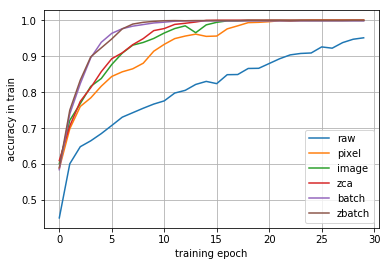

In [39]:
plt.plot(model.history.history["acc"], label="raw");
plt.plot(smodel.history.history["acc"], label="pixel");
plt.plot(s2model.history.history["acc"], label="image");
plt.plot(zmodel.history.history["acc"], label="zca");
plt.plot(bmodel.history.history["acc"], label="batch");
plt.plot(bzmodel.history.history["acc"], label="zbatch");
plt.grid();
plt.legend();
plt.xlabel("training epoch")
plt.ylabel("accuracy in train")